# Simulation and Inference of Interferometry on Growing Thin Films

We are interested in sumulating the reflectance of growing thin films (forward modeling) and infer the growth behavior from measurements.

Caution: This is work in progress.

## Imports

In [1]:
# numerics
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
import optax

# data reading
import pandas as pd

# plotting
import matplotlib.pyplot as plt

# use latex for plotting
# plt.rc('text', usetex=True)

# our library
from reflax import polanalyze, variable_layer_thickness_simulation
from reflax.parameter_classes.parameters import OpticsParams, SetupParams, LayerParams, GrowthModel
from reflax.forward_model.variable_layer_size import power_forward_model
from reflax.data_analysis import cws

## Simulation

### General Setup

Let us first specify parameters of the experimental setup

In [2]:
from reflax.parameter_classes.parameters import SetupParams

wavelength = 632.8
polar_angle = jnp.deg2rad(25)
azimuthal_angle = jnp.deg2rad(0)

setup_params = SetupParams(
    wavelength = wavelength,
    polar_angle = polar_angle,
    azimuthal_angle = azimuthal_angle
)

polarization_state = "Linear TE/perpendicular/s"
transverse_electric_component, transverse_magnetic_component = polanalyze(polarization_state)

We also generally assume

In [3]:
permeability_reflection = 1
permittivity_reflection = 1

permeability_transmission = 1
permittivity_transmission = (3.8827 + 0.019626j)**2

optics_params = OpticsParams(
    permeability_reflection = permeability_reflection,
    permittivity_reflection = permittivity_reflection,
    permeability_transmission = permeability_transmission,
    permittivity_transmission = permittivity_transmission,
    transverse_electric_component = transverse_electric_component,
    transverse_magnetic_component = transverse_magnetic_component
)

backside_mode = 1

and consider a setup with one static-thickness layer with parameters

In [4]:
static_layer_thicknesses = jnp.array([5.0])
permeability_static_size_layers = jnp.array([1.0])
permittivity_static_size_layers = jnp.array([1.45704**2])

static_layer_params = LayerParams(
    permeabilities = permeability_static_size_layers,
    permittivities = permittivity_static_size_layers,
    thicknesses = static_layer_thicknesses
)

Let there further be a layer of variable thickness, with properties

In [5]:
permeability_variable_layer = 1
permittivity_variable_layer = 1.57**2

variable_layer_params = LayerParams(
    permeabilities = permeability_variable_layer,
    permittivities = permittivity_variable_layer
)

### Growth model for the variable layer

We simulate over the timespan

In [6]:
final_time = 7049
time_points = jnp.arange(0, final_time)

Given a linear growth rate

In [7]:
layer_growing_rate = 747.9 / (7049 / 60) / 60

this yields the following thicknesses of the variable layer

In [8]:
variable_layer_thicknesses = time_points * layer_growing_rate

### Running the simulation

In [9]:
reflection_coefficients, transmission_coefficients, conservation_checks = variable_layer_thickness_simulation(
    setup_params = setup_params,
    optics_params = optics_params,
    static_layer_params = static_layer_params,
    variable_layer_params = variable_layer_params,
    variable_layer_thicknesses = variable_layer_thicknesses,
    backside_mode = backside_mode
)

### Profiling the simulation

In [10]:
%%timeit
reflection_coefficients, transmission_coefficients, conservation_checks = jax.block_until_ready(variable_layer_thickness_simulation(
    setup_params = setup_params,
    optics_params = optics_params,
    static_layer_params = static_layer_params,
    variable_layer_params = variable_layer_params,
    variable_layer_thicknesses = variable_layer_thicknesses,
    backside_mode = backside_mode
))

7.3 ms ± 350 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Interactive Plotting

In [11]:
from ipywidgets import interact
import ipywidgets as widgets

from reflax.forward_model.variable_layer_size import forward_model

initial_layer_thickness = 10
layer_growing_acceleration = 5e-7

@interact(static_layer_thickness = widgets.FloatSlider(value = 5, min = 0, max = 50))
def int_plot(static_layer_thickness):
    def plot_model(model):
        sim = forward_model(
            model = model,
            setup_params = setup_params,
            optics_params = optics_params,
            static_layer_params = static_layer_params._replace(thicknesses = jnp.array([static_layer_thickness])),
            variable_layer_params = variable_layer_params,
            variable_layer_thicknesses = initial_layer_thickness + layer_growing_rate * time_points + 1/2 * layer_growing_acceleration * time_points ** 2,
            backside_mode = backside_mode,
            normalization = 0
        )
        plt.plot(time_points, sim * 100, '-', linewidth=1, label="model ({})".format(str(model + 1)))

    plot_model(0)
    plot_model(1)
    plot_model(2)
    plot_model(3)
    plot_model(4)

    plt.xlabel("Time in s")
    plt.ylabel("Reflectivity in %")
    plt.legend(loc="upper right")

interactive(children=(FloatSlider(value=5.0, description='static_layer_thickness', max=50.0), Output()), _dom_…

## Data Analysis

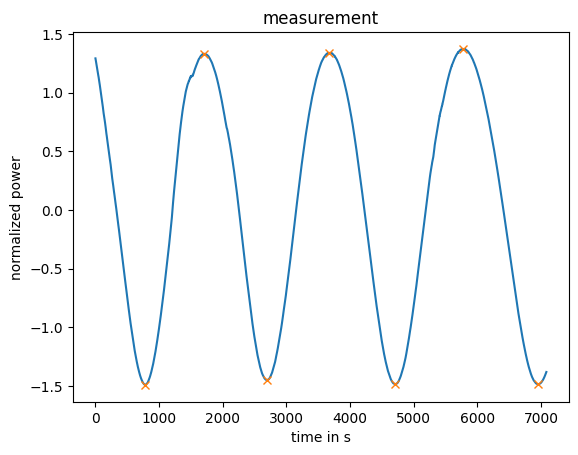

In [12]:
# Define the CSV file path
filename = "2024_11_19_altu_egdma"
# filename = "2024_09_30_senn_EGDMA"

# filename = "2024_11_22_altu_hema_egdma"

file_path = f"data/{filename}.csv"

# Read the CSV, skipping rows until the data table starts
df = pd.read_csv(file_path, sep=';', skiprows=14, decimal=',')
df.columns = df.columns.str.strip()

# Strip whitespace and convert to datetime objects
df['Time'] = pd.to_datetime(df['Time of day (hh:mm:ss)'].str.strip(), format='%H:%M:%S.%f')

# Calculate time since the start
start_time = df['Time'].iloc[0]
df['Time Since Start (seconds)'] = (df['Time'] - start_time).dt.total_seconds()

# Save as jnp arrays
time_points_measured = jnp.asarray(df['Time Since Start (seconds)'])
power_measured = jnp.asarray(df["Power (W)"])

time_points_measured = time_points_measured[300:] - time_points_measured[300]
power_measured = power_measured[300:]

# z-score normalization
power_measured = (power_measured - jnp.mean(power_measured)) / jnp.std(power_measured)

# Display the result
plt.plot(time_points_measured, power_measured)
plt.xlabel("time in s")
plt.ylabel("normalized power")
plt.title("measurement")

# use scipy.find_peaks to find the peaks
from scipy.signal import find_peaks

peaks, _ = find_peaks(power_measured, distance = 100, prominence=0.1)
trophs, _ = find_peaks(-power_measured, distance = 100, prominence=0.1)

# get a sorted list of the local extrema
local_extrema = jnp.sort(jnp.concatenate([peaks, trophs]))

plt.plot(time_points_measured[local_extrema], power_measured[local_extrema], "x")


Text(0, 0.5, 'time difference')

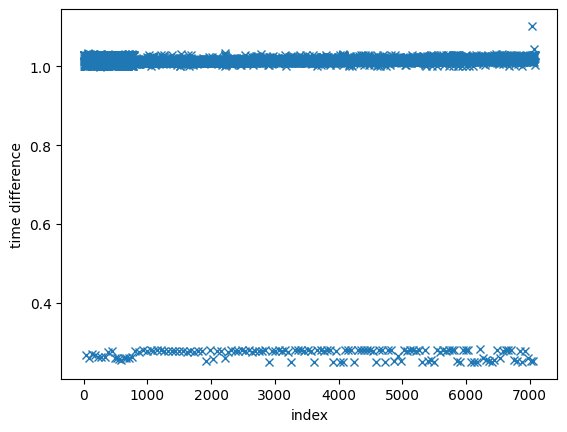

In [13]:
plt.plot(np.diff(time_points_measured), "x")
plt.xlabel("index")
plt.ylabel("time difference")

Text(0, 0.5, 'period in s')

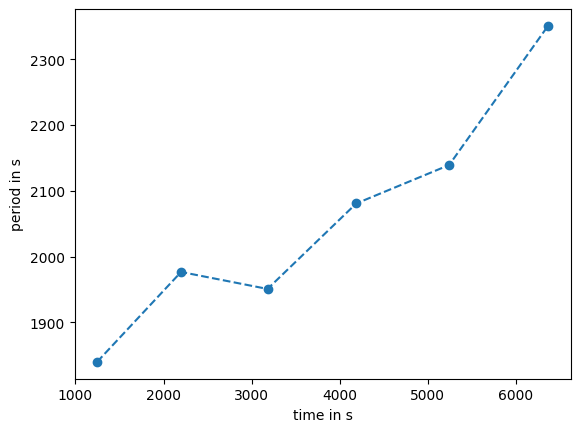

In [14]:
# plot 2 times the difference in time of the local extrema at the middle of the local extrema
midpoints = (time_points_measured[local_extrema][1:] + time_points_measured[local_extrema][:-1]) / 2
periods = 2 * (time_points_measured[local_extrema][1:] - time_points_measured[local_extrema][:-1])

plt.plot(midpoints, periods, "o--")
plt.xlabel("time in s")
plt.ylabel("period in s")

Text(0, 0.5, 'growth velocity in nm/s')

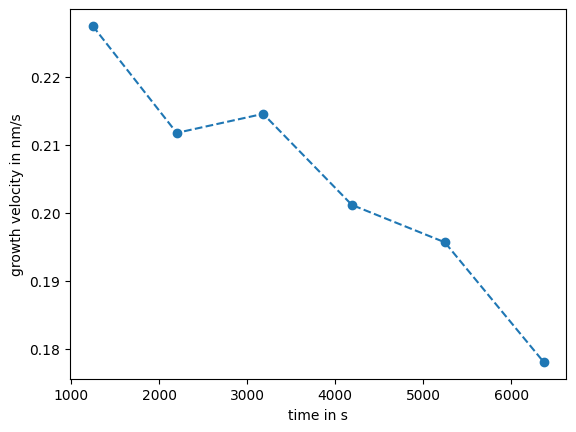

In [15]:
# calculate the period into a growth velocity
n0 = jnp.sqrt(optics_params.permeability_reflection * optics_params.permittivity_reflection)
n1 = jnp.sqrt(variable_layer_params.permeabilities * variable_layer_params.permittivities)
growth_velocities = wavelength * (periods * jnp.sqrt(n1 ** 2 - n0 ** 2 * jnp.sin(jnp.pi - polar_angle) ** 2)) ** -1

plt.plot(midpoints, growth_velocities, "o--")

plt.xlabel("time in s")
plt.ylabel("growth velocity in nm/s")

In [16]:
# find the total growth using the trapezoidal rule
total_growth = jnp.trapezoid(growth_velocities, midpoints)
print(total_growth)

1047.2631766858149


In [17]:
from scipy.signal import periodogram

fs = 1

# Calculate the power spectrum
frequencies, power_spectrum = periodogram(power_measured, fs)

# find the peak frequency
peak_frequency = frequencies[np.argmax(power_spectrum)]

# Display the result
print(f"Peak period: {1 / peak_frequency} s")

Peak period: 2361.3333333333335 s


There seem to be artefacts in the measurement at the beginning up until ~1800 seconds (see the non-smooth transition there). We will cut this part of the measurement away.

In [18]:
# time_points_measured = time_points_measured[300:] - time_points_measured[300]
# power_measured = power_measured[300:]

Only retain frequencies in the correct range,
here preiods of 250s to 750s

In [19]:
# from scipy.signal import butter, filtfilt

# # Define the bandpass filter
# def bandpass_filter(data, lowcut, highcut, fs, order=5):
#     nyquist = 0.5 * fs
#     low = lowcut / nyquist
#     high = highcut / nyquist
#     b, a = butter(order, [low, high], btype='band')
#     y = filtfilt(b, a, data)
#     return y

# # Example usage
# fs = 1  # Sampling frequency (1 measurement per second)
# lowcut = 1/800  # Low cut frequency (1/750 Hz)
# highcut = 1/20  # High cut frequency (1/250 Hz)

# # Apply the bandpass filter
# power_measured_bp = bandpass_filter(power_measured, lowcut, highcut, fs)

In [20]:
# plt.plot(time_points_measured, power_measured_bp)
# plt.xlabel("time in s")
# plt.ylabel("power in W")
# plt.title("cleaned measurement")

### Wavelet analysis

[ 0.     1.028  2.056  3.085  4.113  5.129  6.151  7.164  8.171  9.172
 10.184 11.211 12.213 13.235 14.237 15.237 16.267 17.293 18.294 19.321]


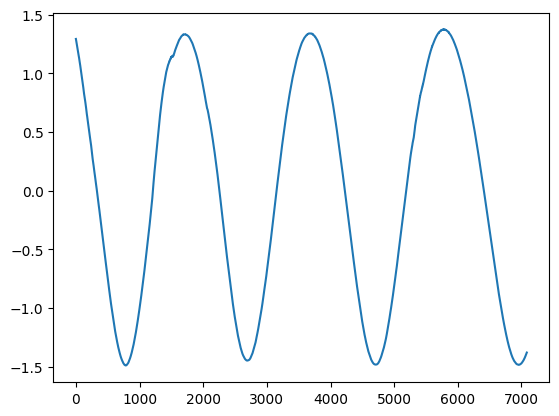

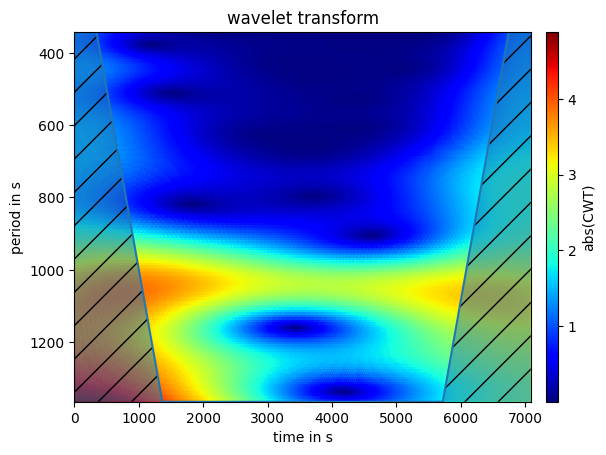

In [21]:
def plot_scaleogram(ax, time_points, signal, title, ylabel = "period in s", xlabel = "time in s", cbarlabel = "abs(CWT)", yscale = "linear", cscale = "linear", scales = np.arange(10, 1000, 10), clim = None, coi = True): # scales = np.arange(100, 2200, 20)
    cws(time = time_points, signal = signal, ax = ax, scales = scales, wavelet="cmor3-1.5", coikw={'alpha':0.5,'hatch':'/'}, ylabel = ylabel, xlabel = xlabel, title = title, cscale = cscale, yscale = yscale, cbarlabel = cbarlabel, clim = clim, coi=coi)

plt.plot(time_points_measured, power_measured)

print(time_points_measured[:20])

fig, ax = plt.subplots()
plot_scaleogram(ax, time_points_measured, power_measured, "wavelet transform", scales = np.arange(500, 2000, 10), coi=True)

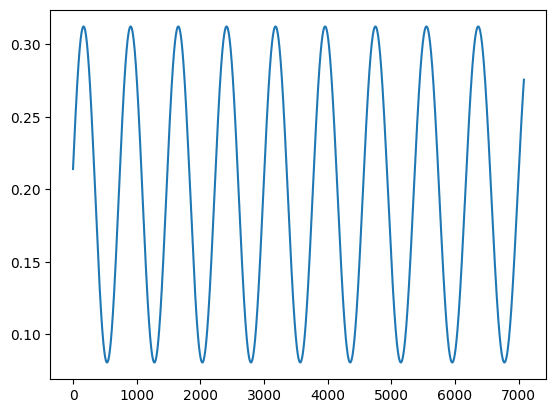

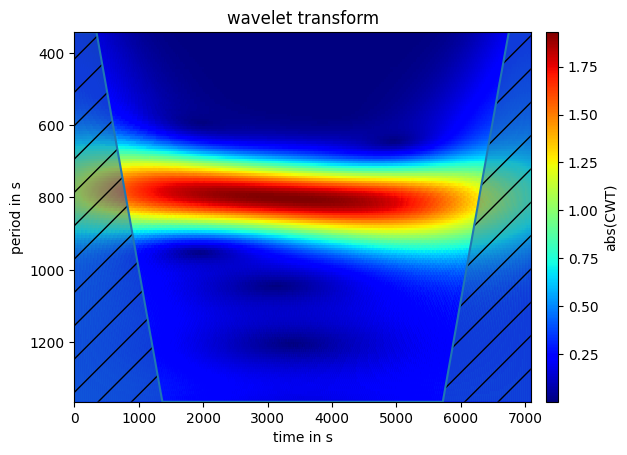

In [61]:
initial_layer_thickness = 170
layer_growing_rate = 0.3
layer_growing_acceleration = -5e-6

power_simulated = forward_model(
    model = 0,
    setup_params = setup_params,
    optics_params = optics_params,
    static_layer_params = static_layer_params,
    variable_layer_params = variable_layer_params,
    variable_layer_thicknesses = initial_layer_thickness + layer_growing_rate * time_points_measured + 1/2 * layer_growing_acceleration * time_points_measured ** 2,
    backside_mode = backside_mode,
    normalization = 4
)

plt.plot(time_points_measured, power_simulated)

fig, ax = plt.subplots()
plot_scaleogram(ax, time_points_measured, power_simulated, "wavelet transform", scales = np.arange(500, 2000, 10), coi=True)

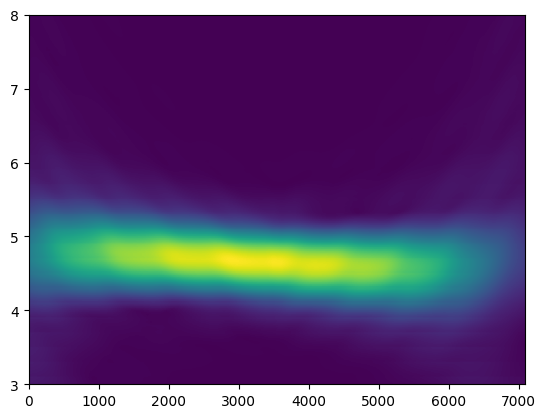

In [76]:
sampling_freq = 3600

from reflax.data_analysis.superlets import adaptive_superlet_transform

freqs = jnp.linspace(3, 8, 200)

scalogram = adaptive_superlet_transform(power_simulated, freqs, sampling_freq=sampling_freq, 
                                        base_cycle=3, min_order=5, max_order=30, mode = 'add')

# scalogram = superlets(signal, sampling_freq, freqs, base_cycle, [min_order, max_order])


# plot the scalogram
fig, ax = plt.subplots()
ax.imshow(jnp.abs(scalogram) ** 2, aspect='auto', origin='lower', extent=[time_points_measured[0], time_points_measured[-1], freqs[0], freqs[-1]])

instantaneous frequency

## Inference

### Inference by hand

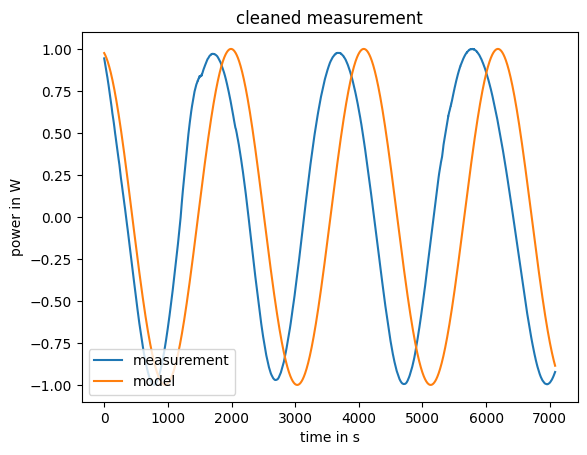

In [24]:
from reflax import power_forward_residuals
from reflax.forward_model.variable_layer_size import forward_model
# initial_layer_thickness = 170
# layer_growing_rate = 747.9 / (7049 / 60) / 60
# layer_growing_acceleration = -0.0000004

# 1.7000000e+02  1.0696702e-01 -5.1498353e-07
# 1.07924394e-01 -6.79976267e-07

initial_layer_thickness = 10
layer_growing_rate = 1.0696702e-01

# layer_growing_rate = 0.25

layer_growing_acceleration = -5.1498353e-07
# layer_growing_acceleration = 0.0

# initial_layer_thickness = 275
# layer_growing_rate = 0.7e-01
# layer_growing_acceleration = -13e-07
# layer_growing_acceleration = 0

permeability_variable_layer = 1
permittivity_variable_layer = 1.50**2

variable_layer_params = LayerParams(
    permeabilities = permeability_variable_layer,
    permittivities = permittivity_variable_layer
)

# simple accelerated model
layer_thickness_model = initial_layer_thickness + layer_growing_rate * time_points_measured + layer_growing_acceleration * time_points_measured ** 2

power_model_z = forward_model(
        model = 2,
        setup_params = setup_params,
        optics_params = optics_params,
        static_layer_params = static_layer_params,
        variable_layer_params = variable_layer_params._replace(permittivities = permittivity_variable_layer),
        variable_layer_thicknesses = initial_layer_thickness + layer_growing_rate * time_points_measured + 1/2 * layer_growing_acceleration * time_points_measured ** 2,
        backside_mode = backside_mode,
        normalization = 0
)

a = 1 / (0.5 * (jnp.max(power_model_z) - jnp.min(power_model_z)))
b = - 0.5 * (jnp.min(power_model_z) + jnp.max(power_model_z)) * a

power_measured_z = (power_measured - 0.5 * (jnp.min(power_measured) + jnp.max(power_measured))) / (0.5 * (jnp.max(power_measured) - jnp.min(power_measured)))

plt.plot(time_points_measured, power_measured_z, label = "measurement")
plt.plot(time_points_measured, power_model_z * a + b, label = "model")
plt.xlabel("time in s")
plt.ylabel("power in W")
plt.title("cleaned measurement")
plt.legend(loc = "lower left")

### Computational optimization

In [25]:
from reflax import power_forward_residuals
from reflax.forward_model.variable_layer_size import forward_model
import optimistix as optx

normalization = 1

if normalization == 0:
    initial_guess_x = jnp.array([initial_layer_thickness, layer_growing_rate, layer_growing_acceleration, a, b])
else:
    initial_guess_x = jnp.array([initial_layer_thickness, layer_growing_rate, layer_growing_acceleration])

power_measured_z = (power_measured - 0.5 * (jnp.min(power_measured) + jnp.max(power_measured))) / (0.5 * (jnp.max(power_measured) - jnp.min(power_measured)))

# ========================== Optim. and Residuals ==========================

def optim_and_res(model, model_str):

    def residuals(params, consts):

        if normalization == 0:
            initial_thickness, growth_velocity, growth_acceleration, a, b = params * initial_guess_x
        else:
            initial_thickness, growth_velocity, growth_acceleration = params * initial_guess_x
        
        power_model_z = forward_model(
            model,
            setup_params = setup_params,
            optics_params = optics_params,
            static_layer_params = static_layer_params,
            variable_layer_params = variable_layer_params, # ._replace(permittivities = variable_layer_permittivity),
            variable_layer_thicknesses = initial_thickness + growth_velocity * time_points_measured + 1/2 * growth_acceleration * time_points_measured ** 2,
            backside_mode = backside_mode,
            normalization = normalization
        )

        if normalization == 0:
            residuals = power_measured_z - (a * power_model_z + b)
        else:
            residuals = power_measured_z - power_model_z

        return residuals

    if normalization == 0:
        initial_guess = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0])
    else:
        initial_guess = jnp.array([1.0, 1.0, 1.0])

    solver = optx.LevenbergMarquardt(
        rtol=1e-8, atol=1e-8
    )

    sol = optx.least_squares(residuals, solver, initial_guess, max_steps=400, throw = False).value

    if normalization == 0:
        initial_thickness, growth_velocity, growth_acceleration, a, b = sol * initial_guess_x
    else:
        initial_thickness, growth_velocity, growth_acceleration = sol * initial_guess_x

    final_thickness = initial_thickness + growth_velocity * time_points_measured[-1] + 1/2 * growth_acceleration * time_points_measured[-1] ** 2

    print("Thickness Results Model " + model_str)
    print("initial thickness: ", initial_thickness)
    print("growth velocity: ", growth_velocity)
    print("growth acceleration: ", growth_acceleration)
    print("final thickness: ", final_thickness)


    power_model_z = forward_model(
            model,
            setup_params = setup_params,
            optics_params = optics_params,
            static_layer_params = static_layer_params,
            variable_layer_params = variable_layer_params, # ._replace(permittivities = variable_layer_permittivity),
            variable_layer_thicknesses = initial_thickness + growth_velocity * time_points_measured + 1/2 * growth_acceleration * time_points_measured ** 2,
            backside_mode = backside_mode,
            normalization = normalization
    )

    if normalization == 0:
        power_model_z = a * power_model_z + b

    residuals_model_z = power_measured_z - power_model_z

    # print the mean absolute residuals
    print("Mean absolute residuals: {}".format(jnp.mean(jnp.abs(residuals_model_z))))

    return power_model_z, residuals_model_z

# ============================================================================

pow1, res1 = optim_and_res(0, "I")
pow2, res2 = optim_and_res(1, "II")
pow3, res3 = optim_and_res(2, "III")
pow4, res4 = optim_and_res(3, "IV")
pow5, res5 = optim_and_res(4, "V")

Thickness Results Model I
initial thickness:  13.869026712586638
growth velocity:  0.12418252776894216
growth acceleration:  -4.52374276601861e-06
final thickness:  780.0061228862846
Mean absolute residuals: 0.07895207063497674
Thickness Results Model II
initial thickness:  15.553685831645991
growth velocity:  0.1228188904458551
growth acceleration:  -4.110765225804369e-06
final thickness:  782.3919226197451
Mean absolute residuals: 0.04758393752889294
Thickness Results Model III
initial thickness:  16.27625889767616
growth velocity:  0.12418270774428548
growth acceleration:  -4.523773740699688e-06
final thickness:  782.4138528421566
Mean absolute residuals: 0.07895228016307837
Thickness Results Model IV
initial thickness:  20.347377014450583
growth velocity:  0.1210005203075158
growth acceleration:  -3.560499223639281e-06
final thickness:  788.109843036847
Mean absolute residuals: 0.039224928377955263
Thickness Results Model V
initial thickness:  13.070351988937329
growth velocity:  0

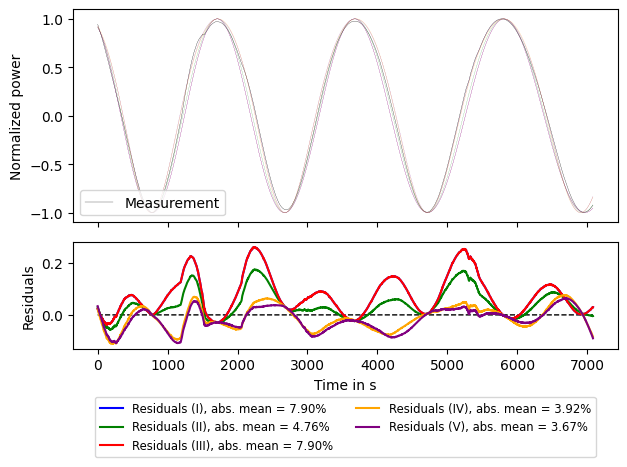

In [26]:
# init plot
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
ax1.plot(time_points_measured, power_measured_z, label="Measurement", color="black", linewidth=0.2)

ax1.legend(loc="lower left")
ax1.set_ylabel("Normalized power")

ax2.set_xlabel("Time in s")
ax2.set_ylabel("Residuals")

ax2.plot(time_points_measured, jnp.zeros_like(time_points_measured), '--k', linewidth=1)

# model 1
color = "blue"
residuals_percentage = jnp.mean(jnp.abs(res1)) * 100
ax1.plot(time_points_measured, pow1, label="model, one layer, no reflections (I)", color=color, linewidth=0.1)
residuals_percentage = jnp.mean(jnp.abs(res1)) * 100
ax2.plot(time_points_measured, res1, label="Residuals (I), abs. mean = {:.2f}%".format(residuals_percentage), color=color)

# model 2
color = "green"
residuals_percentage = jnp.mean(jnp.abs(res2)) * 100
ax1.plot(time_points_measured, pow2, label="model, one layer, reflections (II)", color=color, linewidth=0.1)
residuals_percentage = jnp.mean(jnp.abs(res2)) * 100
ax2.plot(time_points_measured, res2, label="Residuals (II), abs. mean = {:.2f}%".format(residuals_percentage), color=color)

# model 3
color = "red"
residuals_percentage = jnp.mean(jnp.abs(res3)) * 100
ax1.plot(time_points_measured, pow3, label="model, two layers, no reflections (III)", color=color, linewidth=0.1)
residuals_percentage = jnp.mean(jnp.abs(res3)) * 100
ax2.plot(time_points_measured, res3, label="Residuals (III), abs. mean = {:.2f}%".format(residuals_percentage), color=color)

# model 4
color = "orange"
residuals_percentage = jnp.mean(jnp.abs(res4)) * 100
ax1.plot(time_points_measured, pow4, label="model, two layers, reflections (IV)", color=color, linewidth=0.1)
residuals_percentage = jnp.mean(jnp.abs(res4)) * 100
ax2.plot(time_points_measured, res4, label="Residuals (IV), abs. mean = {:.2f}%".format(residuals_percentage), color=color)

# model 5
color = "purple"
residuals_percentage = jnp.mean(jnp.abs(res5)) * 100
ax1.plot(time_points_measured, pow5, label="model, three layers, no reflections (V)", color=color, linewidth=0.1)
residuals_percentage = jnp.mean(jnp.abs(res5)) * 100
ax2.plot(time_points_measured, res5, label="Residuals (V), abs. mean = {:.2f}%".format(residuals_percentage), color=color)

ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.4), ncol=2, fontsize="small")

plt.tight_layout()

plt.savefig("figures/fit_{}_{}.svg".format(filename, "normalized" if normalization == 1 else "ab"))

plt.show()

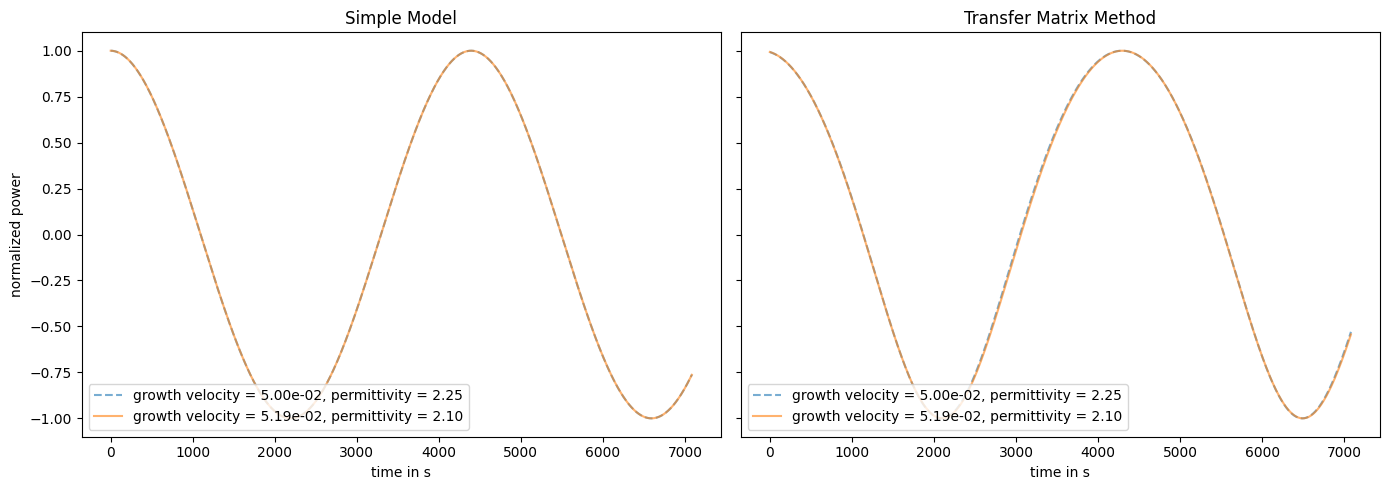

In [27]:
variable_layer_permittivity_A = 1.5**2
variable_layer_permittivity_B = 1.45**2

growth_velocity_A = 5e-2

def delta_var(variable_layer_permittivity):
    n0 = jnp.sqrt(optics_params.permeability_reflection * optics_params.permittivity_reflection)
    n1 = jnp.sqrt(variable_layer_params.permeabilities * variable_layer_permittivity)
    return jnp.sqrt(n1 ** 2 - n0 ** 2 * jnp.sin(setup_params.polar_angle) ** 2)

growth_velocity_B = growth_velocity_A * delta_var(variable_layer_permittivity_A) / delta_var(variable_layer_permittivity_B)

def run_model(model, growth_velocity, variable_layer_permittivity):
    return forward_model(
            model,
            setup_params = setup_params,
            optics_params = optics_params,
            static_layer_params = static_layer_params,
            variable_layer_params = variable_layer_params._replace(permittivities = variable_layer_permittivity),
            variable_layer_thicknesses = growth_velocity * time_points_measured,
            backside_mode = backside_mode
    )

simple_A = run_model(model = 0, growth_velocity = growth_velocity_A, variable_layer_permittivity = variable_layer_permittivity_A)
simple_B = run_model(model = 0, growth_velocity = growth_velocity_B, variable_layer_permittivity = variable_layer_permittivity_B)

tmm_A = run_model(model = 4, growth_velocity = growth_velocity_A, variable_layer_permittivity = variable_layer_permittivity_A)
tmm_B = run_model(model = 4, growth_velocity = growth_velocity_B, variable_layer_permittivity = variable_layer_permittivity_B)

# plot 1x2 with simple model on the left and tmm on the right
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 5))

ax1.plot(time_points_measured, simple_A, "--", alpha = 0.6, label="growth velocity = {:.2e}, permittivity = {:.2f}".format(growth_velocity_A, variable_layer_permittivity_A))
ax1.plot(time_points_measured, simple_B, "-", alpha = 0.6, label="growth velocity = {:.2e}, permittivity = {:.2f}".format(growth_velocity_B, variable_layer_permittivity_B))
ax1.legend(loc="lower left")

ax2.plot(time_points_measured, tmm_A, "--", alpha = 0.6, label="growth velocity = {:.2e}, permittivity = {:.2f}".format(growth_velocity_A, variable_layer_permittivity_A))
ax2.plot(time_points_measured, tmm_B, "-", alpha = 0.6, label="growth velocity = {:.2e}, permittivity = {:.2f}".format(growth_velocity_B, variable_layer_permittivity_B))
ax2.legend(loc="lower left")

ax1.set_title("Simple Model")
ax2.set_title("Transfer Matrix Method")

ax1.set_xlabel("time in s")
ax2.set_xlabel("time in s")
ax1.set_ylabel("normalized power")

plt.tight_layout()

plt.savefig("figures/simple_vs_tmm.png", dpi=300)